# 🏃‍♀️🏃‍♂️ Training

## Load libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import random

## Load cluster information and select a cluster for training

In [2]:
folder_path = '../input/ubiquantfilledv1cluster2of2/'
current_cluster = 2

## Load training, validation and test datasets

In [3]:
X_train = pd.read_parquet(folder_path+'X_train.parquet')
X_valid = pd.read_parquet(folder_path+'X_valid.parquet')
X_test  = pd.read_parquet(folder_path+'X_test.parquet')

y_train = pd.read_parquet(folder_path+'y_train.parquet')
y_valid = pd.read_parquet(folder_path+'y_valid.parquet')
y_test  = pd.read_parquet(folder_path+'y_test.parquet')

## Set the investment and time IDs as indices

In [4]:
X_train = X_train.set_index(['investment_id','time_id'])
y_train = y_train.set_index(['investment_id','time_id'])

X_valid = X_valid.set_index(['investment_id','time_id'])
y_valid = y_valid.set_index(['investment_id','time_id'])

In [5]:
X_train.head()

f_1       f_2       f_3       f_4       f_5  \
investment_id time_id                                                     
1             1190     0.117441  1.336057  0.200028 -0.200948 -0.145147   
              1191     0.304520  0.609152  0.857534 -0.808235 -0.163414   
              1192     1.015338 -0.086064  0.772946 -1.024464 -0.170060   
              1193     1.221100 -0.113554  0.801877 -0.771375 -0.154667   
              1194     1.564061 -0.219084  0.784532 -0.957565 -0.145679   

                            f_6       f_7       f_8       f_9      f_10  ...  \
investment_id time_id                                                    ...   
1             1190    -0.002968 -0.565976  2.336890  0.115572 -0.967807  ...   
              1191     0.862686 -0.825024  2.220720  0.097664  0.275766  ...   
              1192     0.809992 -1.356128  1.833257  0.110023  0.597113  ...   
              1193     0.898420 -1.635045  1.925350  0.194681 -1.619376  ...   
              1194     0.346137 -1.619898  2.104507  0.105881 -0.047761  ...   

                          f_291     f_292     f_293     f_294     f_295  \
investment_id time_id                                                     
1             1190     0.539658  0.170628  0.449091  0.635751  0.947428   
              1191     0.514438  0.545874  3.543956  0.826021  1.163362   
              1192     0.429429  0.939174  1.896151 -0.419295  0.726514   
              1193     0.204661  1.627842 -0.622924  0.001814 -1.291100   
              1194    -0.030007  0.860971 -0.614518 -1.040945  1.300449   

                          f_296     f_297     f_298     f_299     f_300  
investment_id time_id                                                    
1             1190    -0.450420 -0.215100 -0.855532 -1.929326 -0.299557  
              1191    -0.473317 -1.023344 -0.898323 -1.619835 -0.255787  
              1192    -0.328875 -1.003616  0.789994 -0.555073 -0.252515  
              1193    -0.698850  0.028365  0.799687 -0.774808 -0.419649  
              1194    -0.531210 -0.321624  0.289998 -0.814158 -0.401237  

[5 rows x 300 columns]

In [6]:
X_train.columns

Index(['f_1', 'f_2', 'f_3', 'f_4', 'f_5', 'f_6', 'f_7', 'f_8', 'f_9', 'f_10',
       ...
       'f_291', 'f_292', 'f_293', 'f_294', 'f_295', 'f_296', 'f_297', 'f_298',
       'f_299', 'f_300'],
      dtype='object', length=300)

## Prepare the data to be used for training

In [7]:
from tensorflow.keras.preprocessing import sequence

# max number of sequence length
maxlen = 500

# get a list of unique investment IDs
trainId = X_train.index.levels[0]
validId = X_valid.index.levels[0]

# transform the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train_new = [X_train.loc[investment].values for investment in trainId]
y_train_new = [y_train.loc[investment].values for investment in trainId]

X_train_new = np.array(X_train_new, dtype=np.float32)
y_train_new = np.array(y_train_new, dtype=np.float32)

# repeat for the validation data
X_valid_new = [X_valid.loc[investment].values for investment in validId]
y_valid_new = [y_valid.loc[investment].values for investment in validId]

X_valid_new = np.array(X_valid_new, dtype=np.float32)
y_valid_new = np.array(y_valid_new, dtype=np.float32)

In [8]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of investments, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train_new.shape), str(y_train_new.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid_new.shape), str(y_valid_new.shape)))

X_train shape: (1123, 30, 300) | y_train shape: (1123, 30, 1)
X_valid shape: (321, 30, 300) | y_valid shape: (321, 30, 1)


## Compile “Long Short-Term Memory” model

In [9]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.optimizers import RMSprop

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout': 0.25, 'recurrent_dropout': 0.1, 'return_sequences': True, 'implementation': 2}
lstm1 = LSTM(50, name='lstm1', **lstm_kwargs)(mask)

# output: 
output = TimeDistributed(Dense(1), name='output')(lstm1)
model = Model(inputs=x, outputs=output)

# compile model
optimizer = RMSprop(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

2022-03-05 10:16:37.233157: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
input_masked (Masking)       (None, None, 300)         0         
_________________________________________________________________
lstm1 (LSTM)                 (None, None, 50)          70200     
_________________________________________________________________
output (TimeDistributed)     (None, None, 1)           51        
Total params: 70,251
Trainable params: 70,251
Non-trainable params: 0
_________________________________________________________________


## Train model

In [10]:
history = model.fit(X_train_new, y_train_new, batch_size=1, epochs=5, verbose=1)

2022-03-05 10:16:37.760899: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1123/1123 [==============================] - 37s 30ms/step - loss: 0.5663
Epoch 2/5
1123/1123 [==============================] - 35s 31ms/step - loss: 0.5375
Epoch 3/5
1123/1123 [==============================] - 36s 32ms/step - loss: 0.5125
Epoch 4/5
1123/1123 [==============================] - 33s 30ms/step - loss: 0.5364
Epoch 5/5
1123/1123 [==============================] - 35s 31ms/step - loss: 0.5098


## Predict target values for the validation set

In [11]:
preds = model.predict(X_valid_new)
print(preds.shape)

(321, 30, 1)


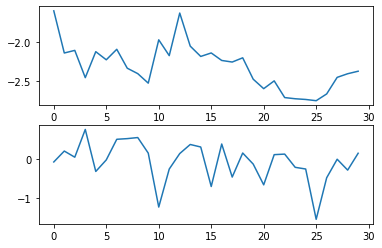

In [12]:
# Choose a random investment to plot
ix = random.randint(0,X_valid_new.shape[0]-1)

# Plot predictions and true values
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(preds[ix,:,0])
ax2.plot(y_valid_new[ix,:,0])

plt.show()


## Plot correlations between true and predicted values

-0.01639419252031244


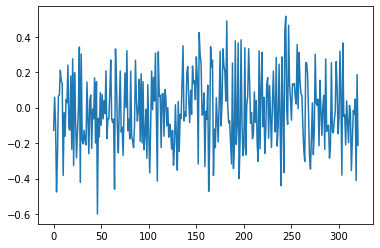

In [13]:
corr = []
for i in range(preds.shape[0]):
    x =np.corrcoef(preds[i,:,0],y_valid_new[i,:,0])
    corr.append(x[0][1])
    
print(np.mean(corr))
plt.plot(corr)
plt.show()

## Save trained model

In [14]:
# import os
# os.mkdir('./Model'+str(current_cluster))

In [15]:
# model.save('./Model'+str(current_cluster))

In [16]:
# import shutil
# shutil.make_archive('Model'+str(current_cluster), 'zip', './Model'+str(current_cluster))